In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import glob
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn as sns
from tqdm import tqdm


import copy
import pandas as pd
import numpy as np
import torch

from sklearn.metrics import roc_auc_score

os.environ["WANDB_SILENT"] = "true"

from owkin.training import train, RocLoss
from owkin.dataset import build_dataset
from owkin.models.mono_models import MLP, SVM
from owkin.models.aggregators import SmoothMaxAggregator, MaxAggregator

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

from scipy.stats import t, norm

from statistics import variance, mean 

import math


## TODO:

Look at the differences between the centers

train_val = [C_1, C_2, C5]

test = [C_3, C_4]

## Observation:

- a correction is needed for each center, especially C_4, but also C_3 and C_5 
- the distributions follows a shifted/troncated exponential low, parametrized by a `lambda_expo` (esperance of the hidden exponential law) and a `shift`.
- to normalize: divide by `lambda_expo` or by the esperance (we don't want to shift to keep feature positive and avoid the peak to be elsewhere to 0)

In [3]:
data_path = "../data/"
"""
Build `X_train_mean, X_val_mean, X_train, X_val, y_train, y_val`
TODO: add other aggregation that mean (e.g. max) ? Use a dict ?
"""

# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path(data_path)

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train_val = pd.read_csv(data_dir / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir / "supplementary_data" / "test_metadata.csv")


# concatenate y_train_val and df_train_val
y_train_val = pd.read_csv(data_dir / "train_output.csv")
df_train_val = df_train_val.merge(y_train_val, on="Sample ID")

In [4]:
X_train_val_mean = []
X_train_val = []
y_train_val = []

centers_train_val = []
patients_train_val = []

for sample, label, center, patient in df_train_val[
    ["Sample ID", "Target", "Center ID", "Patient ID"]
].values:
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks

    # slide-level averaging
    X_train_val_mean.append(np.mean(features, axis=0))
    X_train_val.append(features)
    y_train_val.append(label)

    centers_train_val.append(center)
    patients_train_val.append(patient)

# convert to numpy arrays
X_train_val_mean = np.array(X_train_val_mean)
X_train_val = np.array(X_train_val)
y_train_val = np.array(y_train_val)

centers_train_val = np.array(centers_train_val)
patients_train_val = np.array(patients_train_val)

patients_unique = np.unique(patients_train_val)
y_unique = np.array(
    [np.mean(y_train_val[patients_train_val == p]) for p in patients_unique]
)


X_test = []
X_test_mean = []
centers_test = []
patients_test = []


# load the data from `df_test` (~ 1 minute)
for sample, center, patient in df_test[
    ["Sample ID", "Center ID", "Patient ID"]
].values:
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(features)
    X_test_mean.append(np.mean(features, axis=0))
    centers_test.append(center)
    patients_test.append(patient)

X_test = np.array(X_test)
X_test_mean = np.array(X_test_mean)

centers_test = np.array(centers_test)
patients_test = np.array(patients_test)

In [5]:
num_feature = X_train_val.shape[-1]

centers = ["C_1", "C_2", "C_5", "C_3", "C_4"]

In [6]:
X_all = np.concatenate([X_train_val, X_test], axis=0)
centers_all = np.concatenate([centers_train_val, centers_test])

X_all_flat = X_all.reshape(-1, num_feature)
X_train_val_flat = X_train_val.reshape([-1, num_feature])

In [7]:
def find_expo_param(values):
    p0 = (values == 0).mean()
    list_p = np.linspace((9*p0+1)/10, (p0+9)/10, 100)

    Y = -np.quantile(values, list_p)/np.log(1-list_p)
    A = np.array([np.ones_like(list_p), 1/np.log(1-list_p)]).T

    res = np.linalg.inv(A.T@A) @ A.T @ Y

    return res[0], res[1]

In [8]:
X = dict()
X_flat = dict()
X_flat_sort = dict()

for center in centers:
    X[center] = X_all[centers_all == center]
    X_flat[center] = X[center].reshape(-1, num_feature)
    X_flat_sort[center] = X[center].reshape(-1, num_feature).copy()
    X_flat_sort[center].sort(axis=0)

In [9]:
mean_normalizer = dict()
expo_lambda_normalizer = dict()
for center in centers:
    mean_normalizer[center] = np.zeros(num_feature)
    expo_lambda_normalizer[center] = np.zeros(num_feature)
    for feature in range(num_feature):
        values = X_flat_sort[center][:,feature]
        expo_lambda, shift = find_expo_param(values)
        expo_lambda_normalizer[center][feature] = expo_lambda
        mean_normalizer[center][feature] = values.mean()

In [22]:
for center in centers:
    PATH_DIR = Path("./../data/normalizer/mean/")
    if not PATH_DIR.is_dir():
        os.makedirs(PATH_DIR)
    np.save(f"{PATH_DIR}/{center}", mean_normalizer[center])
    PATH_DIR = Path("./../data/normalizer/expo_lambda/")
    if not PATH_DIR.is_dir():
        os.makedirs(PATH_DIR)
    np.save(f"{PATH_DIR}/{center}", expo_lambda_normalizer[center])

In [17]:
np.load(f"{PATH_DIR}/{center}.npy").shape

(2048,)

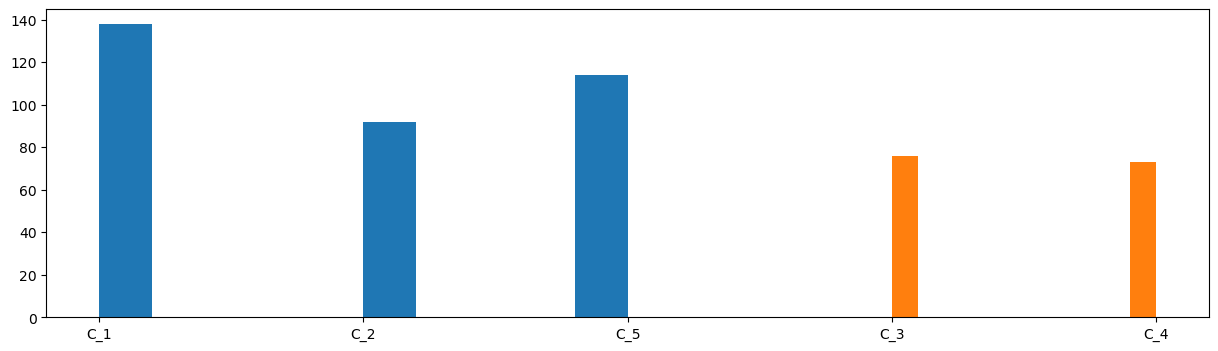

In [5]:
plt.figure(figsize=(15,4))
plt.hist(centers_train_val, label = "train")
plt.hist(centers_test, label = "test")
plt.show()

In [6]:
num_feature = X_train_val.shape[-1]

centers = ["C_1", "C_2", "C_5", "C_3", "C_4"]

colors = {
    #train_val
    "C_1": "lime",
    "C_2": "blue",
    "C_5": "cyan",
    #test
    "C_3": "magenta",
    "C_4": "red",
    #all
    "all": "grey",
    "train_val": "black"
}

In [7]:
y = dict()
for center in centers[:-2] :
    y[center] = y_train_val[centers_train_val == center]
    nb_pos = y[center].sum()
    nb_neg = (1-y[center]).sum()
    print(f"center {center}: {nb_pos} positive and {nb_neg} negative, for a proportion of {nb_pos/(nb_pos+nb_neg)}")

center C_1: 49 positive and 89 negative, for a proportion of 0.35507246376811596
center C_2: 33 positive and 59 negative, for a proportion of 0.358695652173913
center C_5: 46 positive and 68 negative, for a proportion of 0.40350877192982454


In [8]:
X_all = np.concatenate([X_train_val, X_test], axis=0)
centers_all = np.concatenate([centers_train_val, centers_test])

X_all_flat = X_all.reshape(-1, num_feature)
X_train_val_flat = X_train_val.reshape([-1, num_feature])

## Without any scale

In [9]:
X = dict()
X_flat = dict()
X_flat_sort = dict()

for center in centers:
    X[center] = X_all[centers_all == center]
    X_flat[center] = X[center].reshape(-1, num_feature)
    X_flat_sort[center] = X[center].reshape(-1, num_feature).copy()
    X_flat_sort[center].sort(axis=0)


X["all"] = X_all
X_flat["all"] = X_all_flat
X_flat_sort["all"] = X_all_flat.copy()
X_flat_sort["all"].sort(axis=0)

X["train_val"] = X_train_val
X_flat["train_val"] = X_train_val_flat
X_flat_sort["train_val"] = X_train_val_flat.copy()
X_flat_sort["train_val"].sort(axis=0)

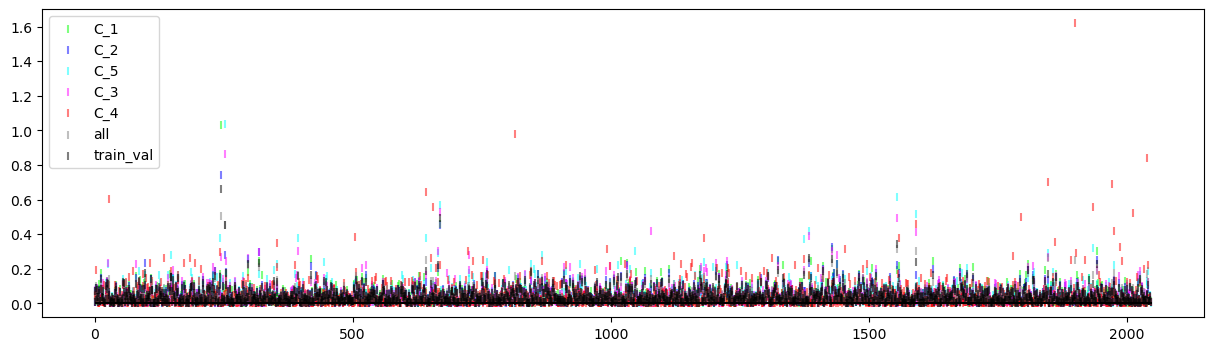

In [10]:
plt.figure(figsize=(15,4))

for center in X_flat.keys():
    plt.scatter(np.arange(num_feature), X_flat[center].mean(axis=0), label = center, alpha=0.5, marker="|", color=colors[center])

plt.hlines(0, 0, num_feature, color="black")

plt.legend()
plt.show()

### Max of each lime

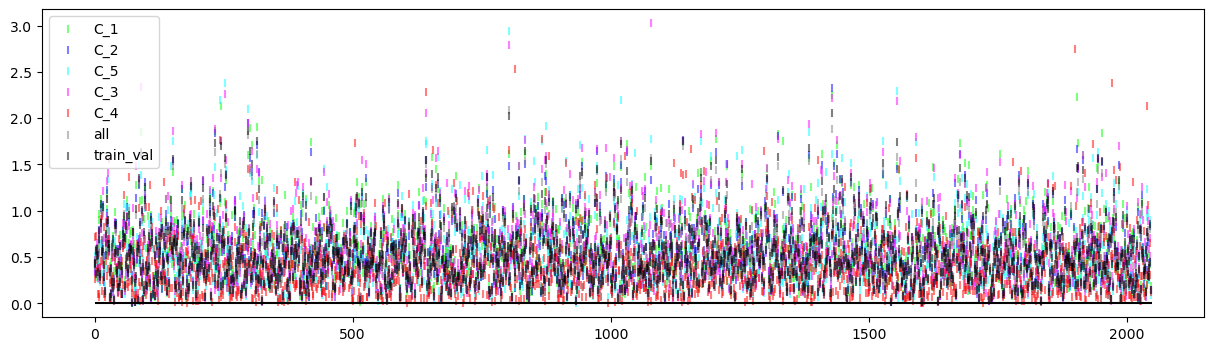

In [11]:
plt.figure(figsize=(15,4))

for center in X_flat.keys():
    plt.scatter(np.arange(num_feature), X[center].max(axis=1).mean(axis=0), label = center, alpha=0.5, marker="|", color=colors[center])

plt.hlines(0, 0, num_feature, color="black")

plt.legend()
plt.show()

## Find the distribution of the data

In [12]:
center = "C_1"
p = 1. * np.arange(X_flat_sort[center].shape[0]) / (X_flat_sort[center].shape[0] - 1)

In [13]:
list_colors = list(mcolors.XKCD_COLORS.keys())
len(list_colors)

949

### CDF of different features

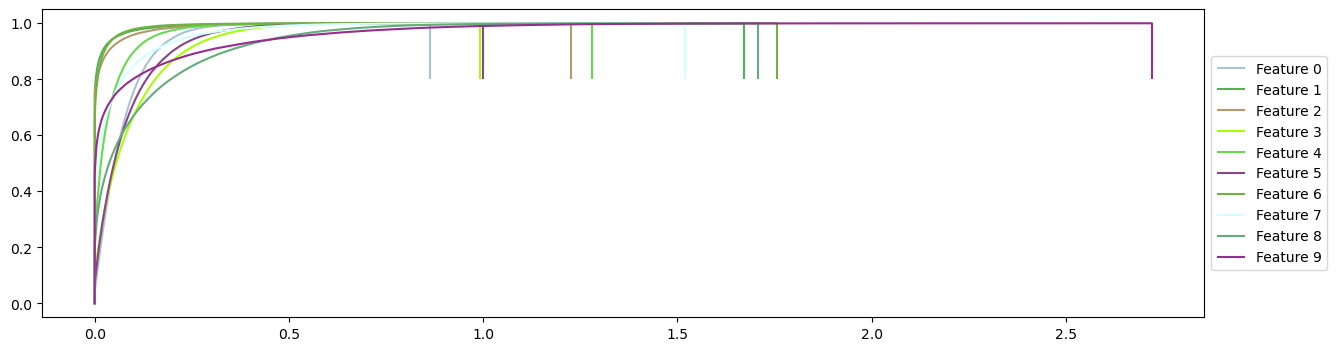

In [14]:
plt.figure(figsize=(15,4))
for i in range(10):
    plt.plot(X_flat_sort[center][:,i], p, c=list_colors[i])
    plt.vlines(X_flat_sort[center][:,i][-1], 0.8, 1, label=f"Feature {i}", colors=list_colors[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
def find_gaussian_param(values):
    p0 = (values == 0).mean()
    list_p = np.linspace((9*p0+1)/10, (p0+9)/10, 100)

    Y = np.quantile(values, list_p)
    A = np.array([np.ones_like(list_p), norm.ppf(list_p)]).T

    res = np.linalg.inv(A.T@A) @ A.T @ Y

    return res[0], res[1]

In [16]:
def find_expo_param(values):
    p0 = (values == 0).mean()
    list_p = np.linspace((9*p0+1)/10, (p0+9)/10, 100)

    Y = -np.quantile(values, list_p)/np.log(1-list_p)
    A = np.array([np.ones_like(list_p), 1/np.log(1-list_p)]).T

    res = np.linalg.inv(A.T@A) @ A.T @ Y

    return res[0], res[1]

### Approximation by Gaussian and exponential model

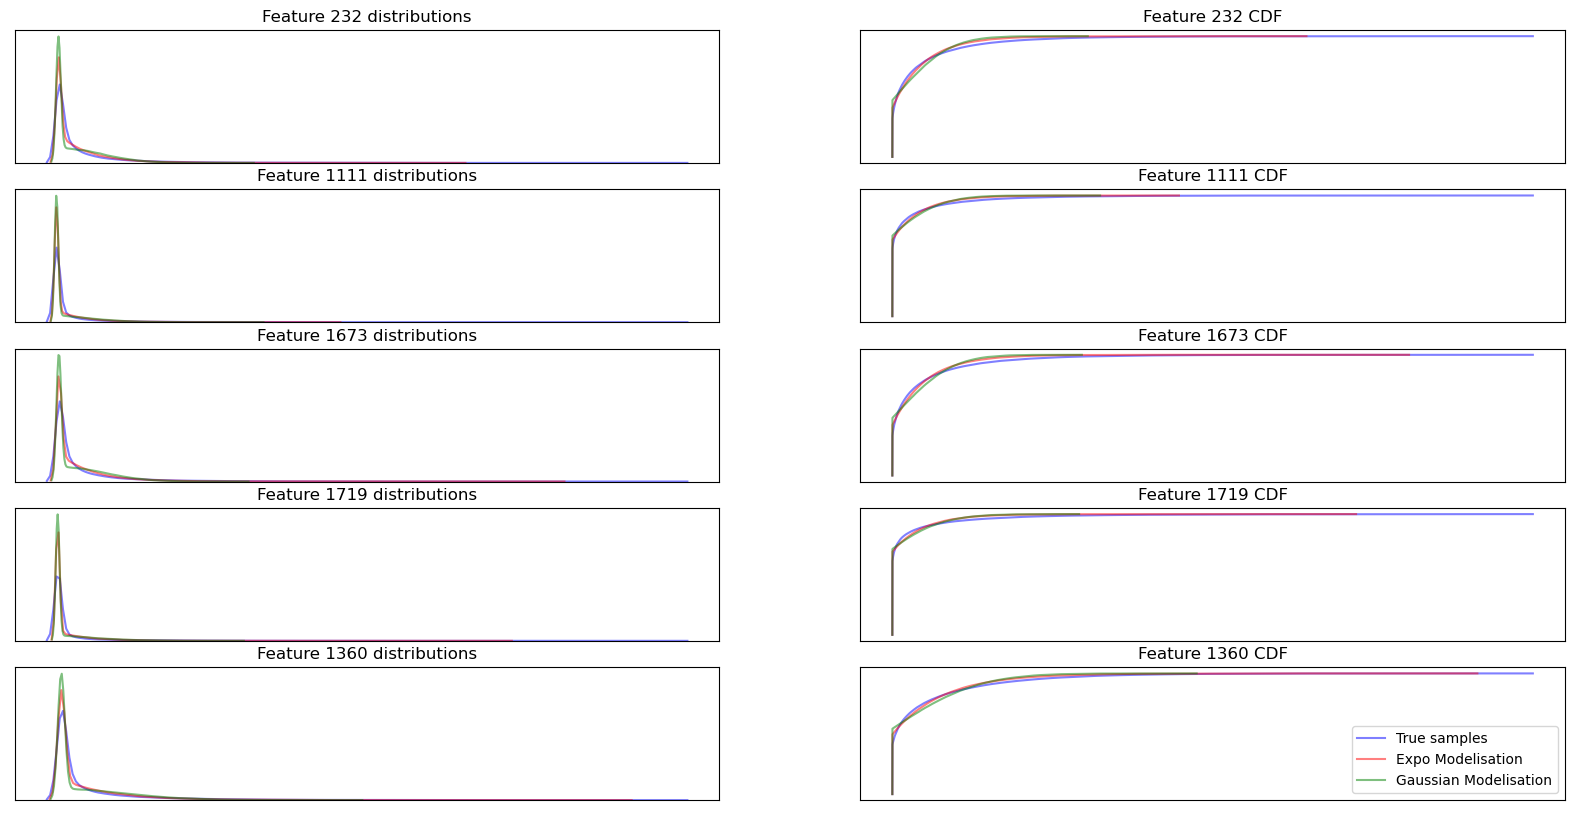

In [17]:
nb_lines=5
nb_col=1
fig, ax = plt.subplots(nb_lines, 2*nb_col, figsize=(20,2*nb_lines))
for i in range(nb_lines) :
    for j in range(nb_col) :
        feature = np.random.randint(0, num_feature)
        values = X_flat_sort[center][:,feature]

        expo_lambda, shift = find_expo_param(values)
        expo_points = np.random.exponential(expo_lambda, p.shape[0])-shift
        expo_points = np.maximum(0,expo_points)
        expo_points.sort()

        norm_mu, norm_sigma = find_gaussian_param(values)
        norm_points = np.random.normal(norm_mu, norm_sigma, p.shape[0])
        norm_points = np.maximum(0,norm_points)
        norm_points.sort()

        sns.kdeplot(values, color="blue", ax=ax[i, 2*j], label = "True samples", alpha=0.5)
        sns.kdeplot(expo_points, color="red", ax=ax[i, 2*j], label = "Expo Modelisation", alpha=0.5)
        sns.kdeplot(norm_points, color="g", ax=ax[i, 2*j], label = "Gaussian Modelisation", alpha=0.5)
        ax[i, 2*j].set_title(f"Feature {feature} distributions")


        ax[i, 2*j+1].plot(values,p, color="blue", label = "True samples",alpha=0.5)
        ax[i, 2*j+1].plot(expo_points, p, color="red", label = "Expo Modelisation", alpha=0.5)
        ax[i, 2*j+1].plot(norm_points, p, color="g", label = "Gaussian Modelisation", alpha=0.5)
        ax[i, 2*j+1].set_title(f"Feature {feature} CDF")

        ax[i, 2*j].get_xaxis().set_visible(False)
        ax[i, 2*j].get_yaxis().set_visible(False)
        ax[i, 2*j+1].get_xaxis().set_visible(False)
        ax[i, 2*j+1].get_yaxis().set_visible(False)

plt.legend(loc="lower right")
plt.show()

### Fixed feature different centers approximation

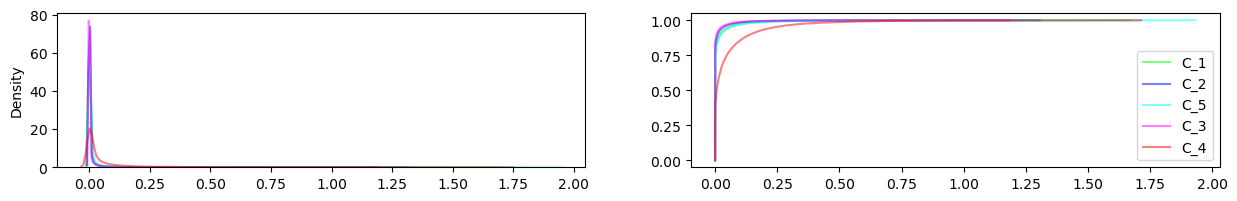

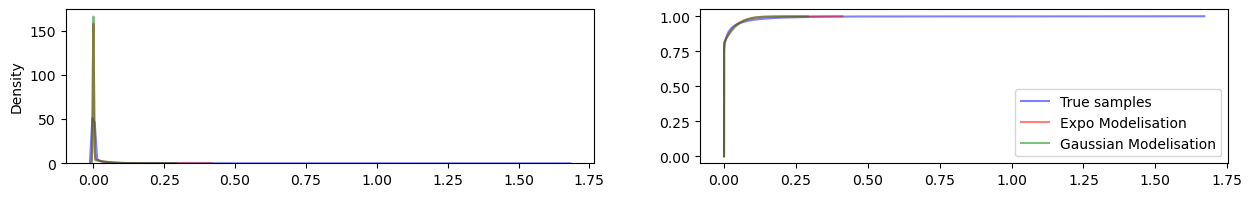

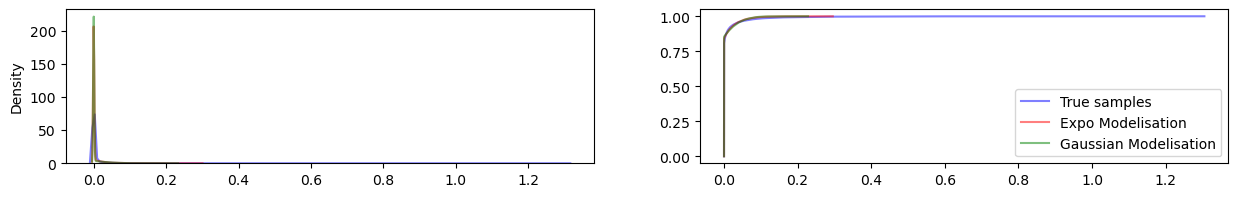

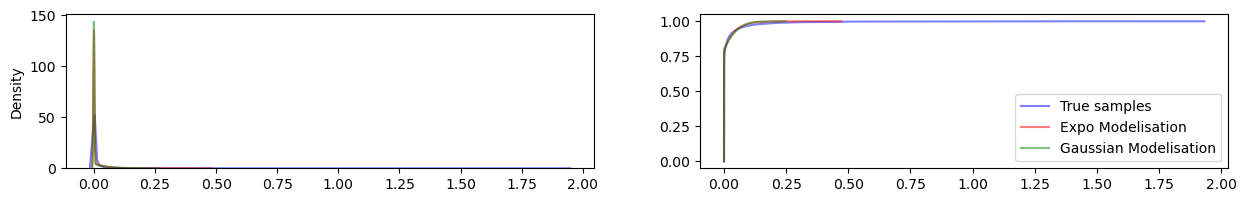

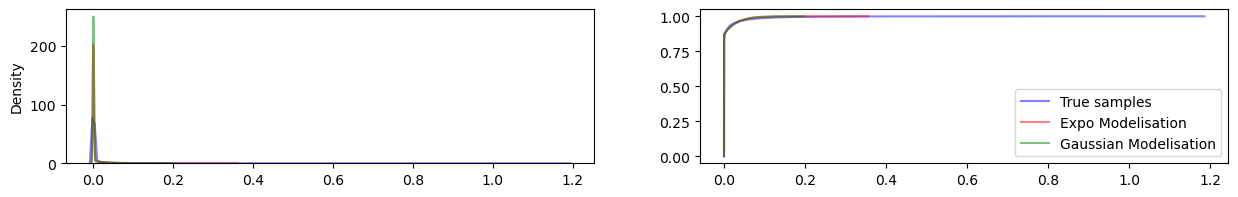

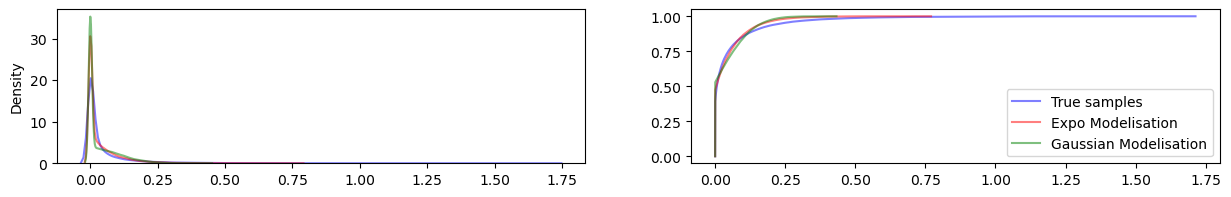

In [18]:
feature = 1

fig, ax = plt.subplots(1,2,figsize=(15,2))
for center in centers:
    values = X_flat_sort[center][:,feature]
    p = 1. * np.arange(X_flat_sort[center].shape[0]) / (X_flat_sort[center].shape[0] - 1)
    sns.kdeplot(values, ax=ax[0], alpha=0.5, color=colors[center])
    ax[1].plot(values,p, label = center, alpha=0.5, color=colors[center])

plt.legend()
plt.show()

for center in centers:
    values = X_flat_sort[center][:,feature]
    p = 1. * np.arange(X_flat_sort[center].shape[0]) / (X_flat_sort[center].shape[0] - 1)

    expo_lambda, shift = find_expo_param(values)
    expo_points = np.random.exponential(expo_lambda, p.shape[0])-shift
    expo_points = np.maximum(0,expo_points)
    expo_points.sort()

    norm_mu, norm_sigma = find_gaussian_param(values)
    norm_points = np.random.normal(norm_mu, norm_sigma, p.shape[0])
    norm_points = np.maximum(0,norm_points)
    norm_points.sort()

    fig, ax = plt.subplots(1,2, figsize=(15,2))
    sns.kdeplot(values, color="blue", ax=ax[0], alpha=0.5)
    sns.kdeplot(expo_points, color="red", ax=ax[0], alpha=0.5)
    sns.kdeplot(norm_points, color="g", ax=ax[0], alpha=0.5)


    ax[1].plot(values,p, color="blue", label = "True samples", alpha=0.5)
    ax[1].plot(expo_points, p, color="red", label = "Expo Modelisation", alpha=0.5)
    ax[1].plot(norm_points, p, color="g", label = "Gaussian Modelisation", alpha=0.5)

    plt.legend()
    plt.show()

### Simulated sampled comparison

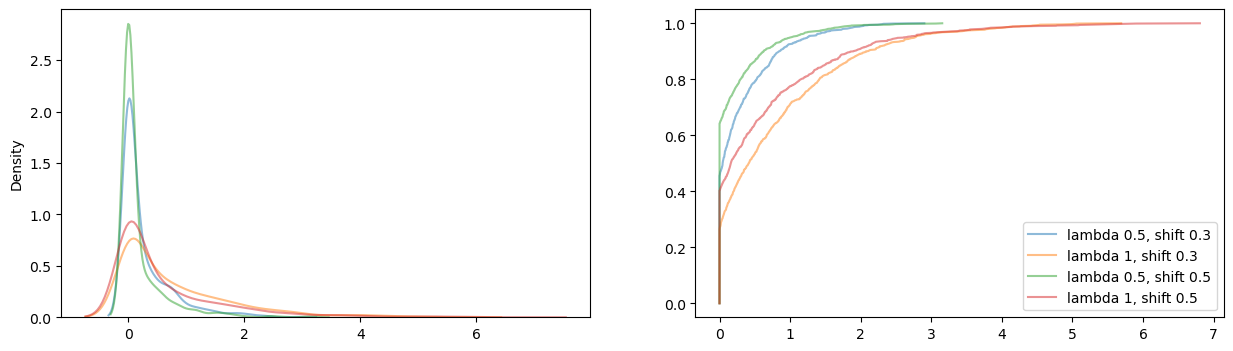

In [19]:
n = 1000
p_all = 1. * np.arange(n) / (n - 1)

fig, ax = plt.subplots(1,2, figsize=(15,4))
for shift in [0.3,0.5]:
    for expo_lambda in [0.5, 1]:
        expo_points = np.random.exponential(expo_lambda, p_all.shape[0])-shift
        expo_points = np.maximum(0,expo_points)
        expo_points.sort()
        
        sns.kdeplot(expo_points, ax=ax[0], alpha=0.5, label = f"lambda {expo_lambda}, shift {shift}")
        ax[1].plot(expo_points, p_all, alpha=0.5, label = f"lambda {expo_lambda}, shift {shift}")

plt.legend()
plt.show()

### Normalisation comparison

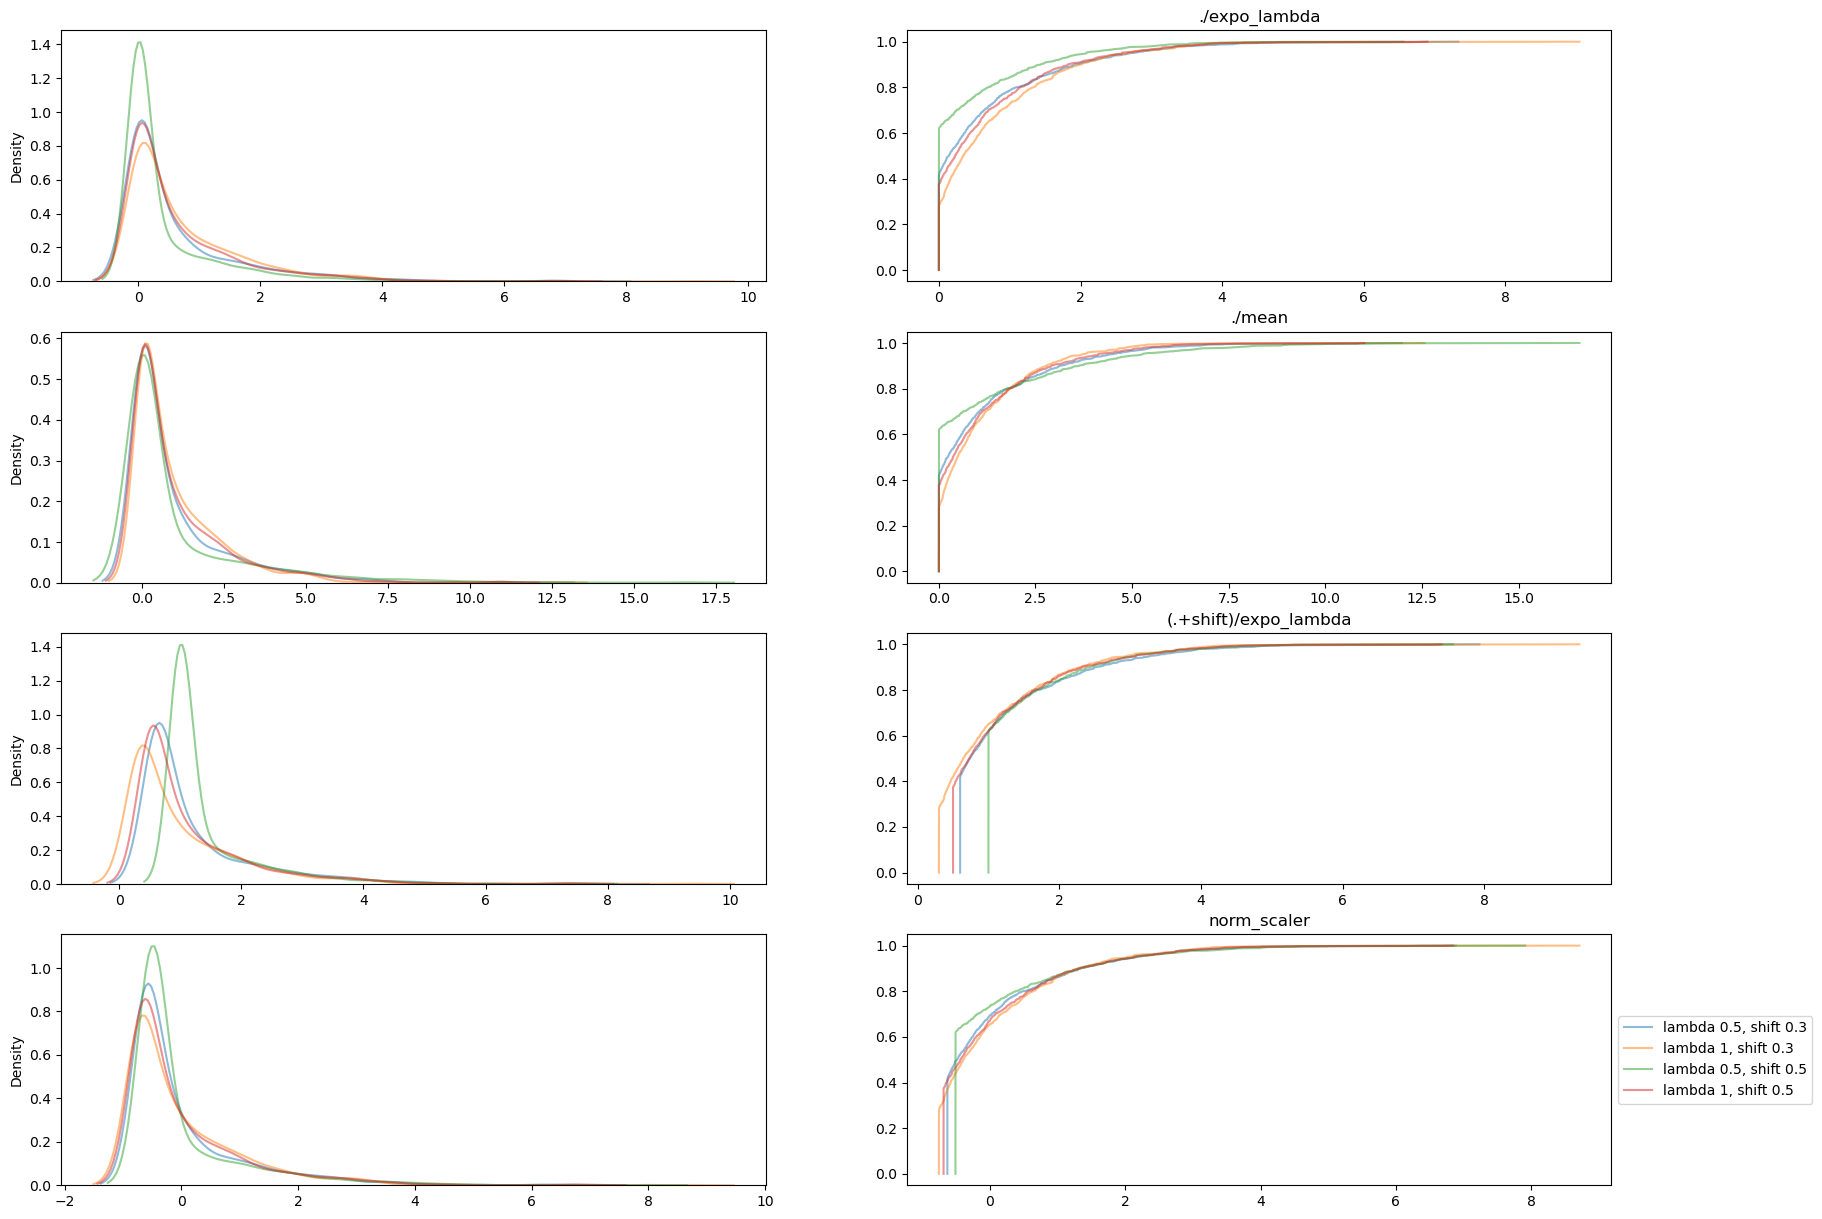

In [20]:
fig, ax = plt.subplots(4,2, figsize=(20,15))
for shift in [0.3,0.5]:
    for expo_lambda in [0.5, 1]:
        expo_points = np.random.exponential(expo_lambda, p_all.shape[0])-shift
        expo_points = np.maximum(0,expo_points)
        expo_points.sort()
        expo_points_normalized = (expo_points)/expo_lambda


        sns.kdeplot(expo_points_normalized, ax=ax[0, 0], alpha=0.5, label = f"lambda {expo_lambda}, shift {shift}")
        ax[0, 1].plot(expo_points_normalized, p_all, alpha=0.5, label = f"lambda {expo_lambda}, shift {shift}")
        ax[0, 1].set_title("./expo_lambda")

        expo_points_normalized = expo_points/expo_points.mean()
        sns.kdeplot(expo_points_normalized, ax=ax[1, 0], alpha=0.5, label = f"lambda {expo_lambda}, shift {shift}")
        ax[1, 1].plot(expo_points_normalized, p_all, alpha=0.5, label = f"lambda {expo_lambda}, shift {shift}")
        ax[1, 1].set_title("./mean")

        expo_points_normalized = (expo_points + shift)/expo_lambda
        sns.kdeplot(expo_points_normalized, ax=ax[2, 0], alpha=0.5, label = f"lambda {expo_lambda}, shift {shift}")
        ax[2, 1].plot(expo_points_normalized, p_all, alpha=0.5, label = f"lambda {expo_lambda}, shift {shift}")
        ax[2, 1].set_title("(.+shift)/expo_lambda")


        expo_points_normalized = (expo_points-expo_points.mean())/expo_points.std()
        sns.kdeplot(expo_points_normalized, ax=ax[3, 0], alpha=0.5, label = f"lambda {expo_lambda}, shift {shift}")
        ax[3, 1].plot(expo_points_normalized, p_all, alpha=0.5, label = f"lambda {expo_lambda}, shift {shift}")
        ax[3, 1].set_title("norm_scaler")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### mean in function of shift and expo_lambda

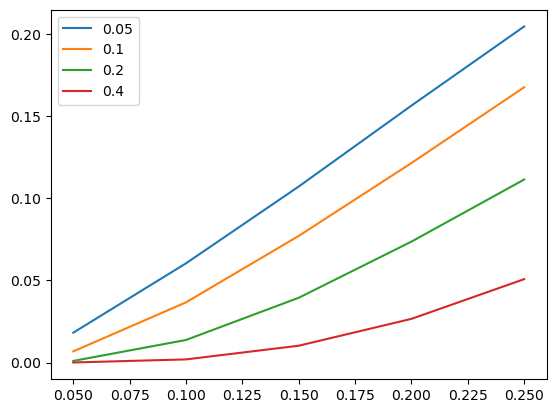

In [44]:
list_shift = [0.05, 0.1, 0.2, 0.4]
list_expo_lambda = [0.05, 0.1, 0.15 ,0.2, 0.25]

for i, shift in enumerate(list_shift):
    list_mean = []
    for j, expo_lambda in enumerate(list_expo_lambda):
        expo_points = np.random.exponential(expo_lambda, p_all.shape[0])-shift
        expo_points = np.maximum(0,expo_points)
        list_mean.append(expo_points.mean())
    plt.plot(list_expo_lambda, list_mean, label=shift)
plt.legend()
plt.show()

### expo_lambda, mean and shift comparison between centers

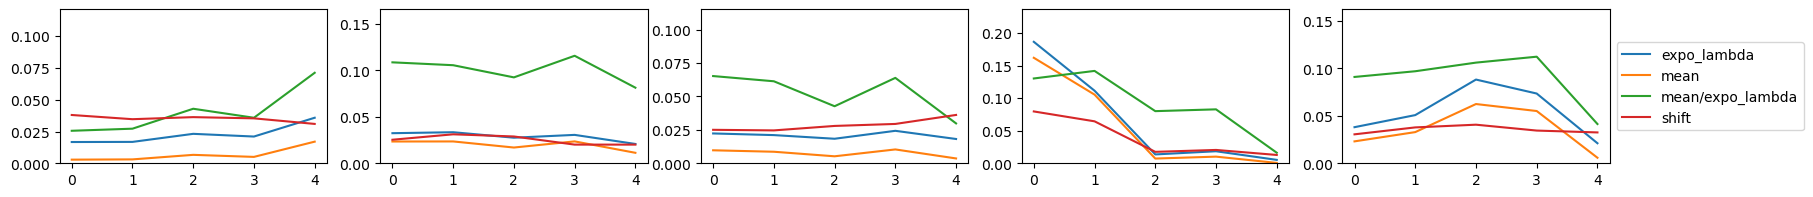

In [45]:
nb_plot = 5
fig, ax = fig, ax = plt.subplots(1, nb_plot, figsize=(20,2))
for i in range(nb_plot):
    feature = np.random.randint(0, 2048)
    expo_lambda_list, mean_list, shift_list = [], [], []
    for center in centers:
        values = X_flat_sort[center][:,feature]
        expo_lambda, shift = find_expo_param(values)
        expo_lambda_list.append(expo_lambda)
        mean_list.append(values.mean())
        shift_list.append(shift)

    ratio_list = list(0.15*np.array(mean_list)/np.array(expo_lambda_list))
    ax[i].plot(expo_lambda_list, label="expo_lambda")
    ax[i].plot(mean_list, label="mean")
    ax[i].plot(ratio_list, label="mean/expo_lambda")
    ax[i].plot(shift_list, label="shift")
    ax[i].set_ylim(0,max(expo_lambda_list+mean_list+shift_list+ratio_list)+0.05)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Normalisation Comparison between centers

922


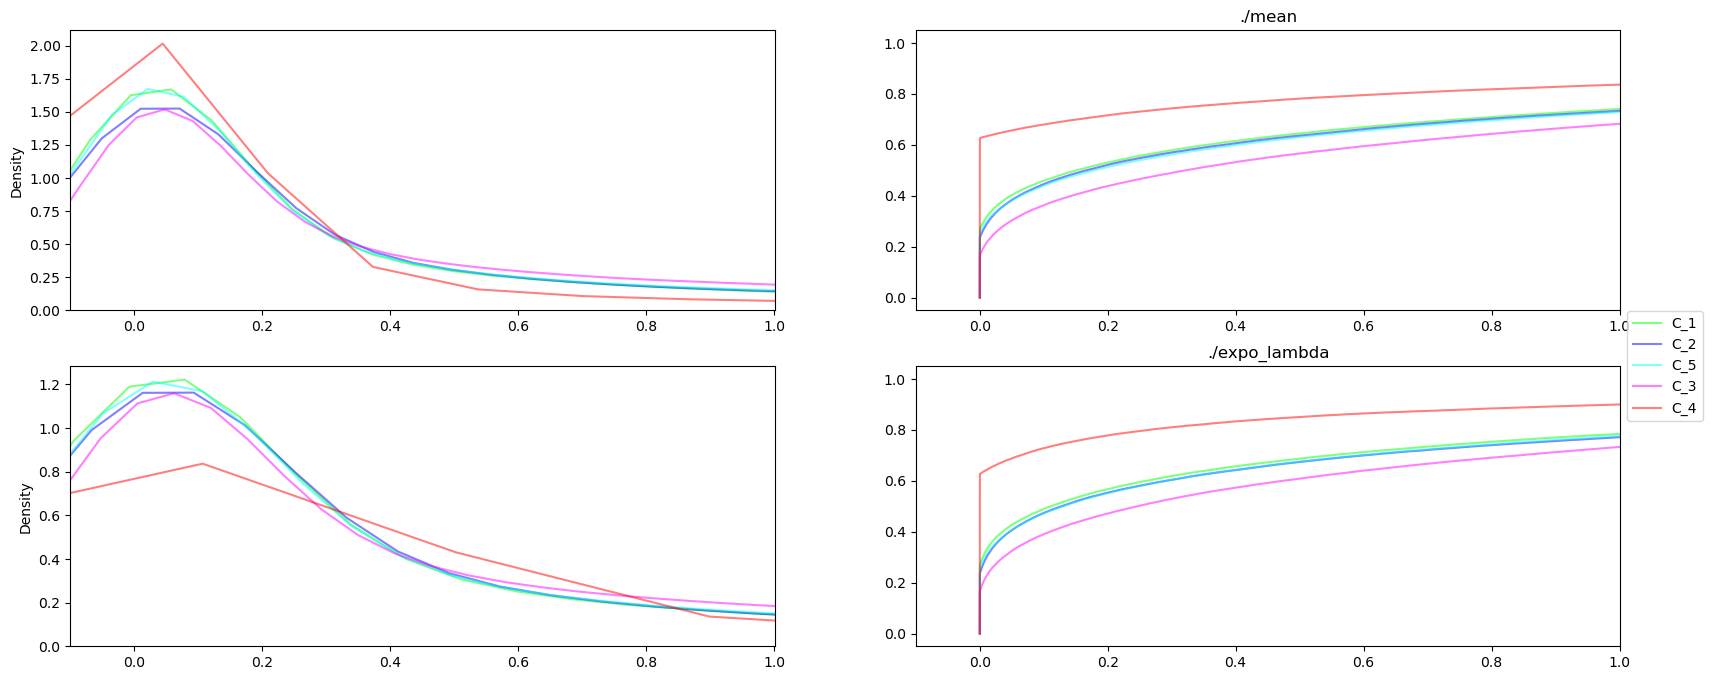

10


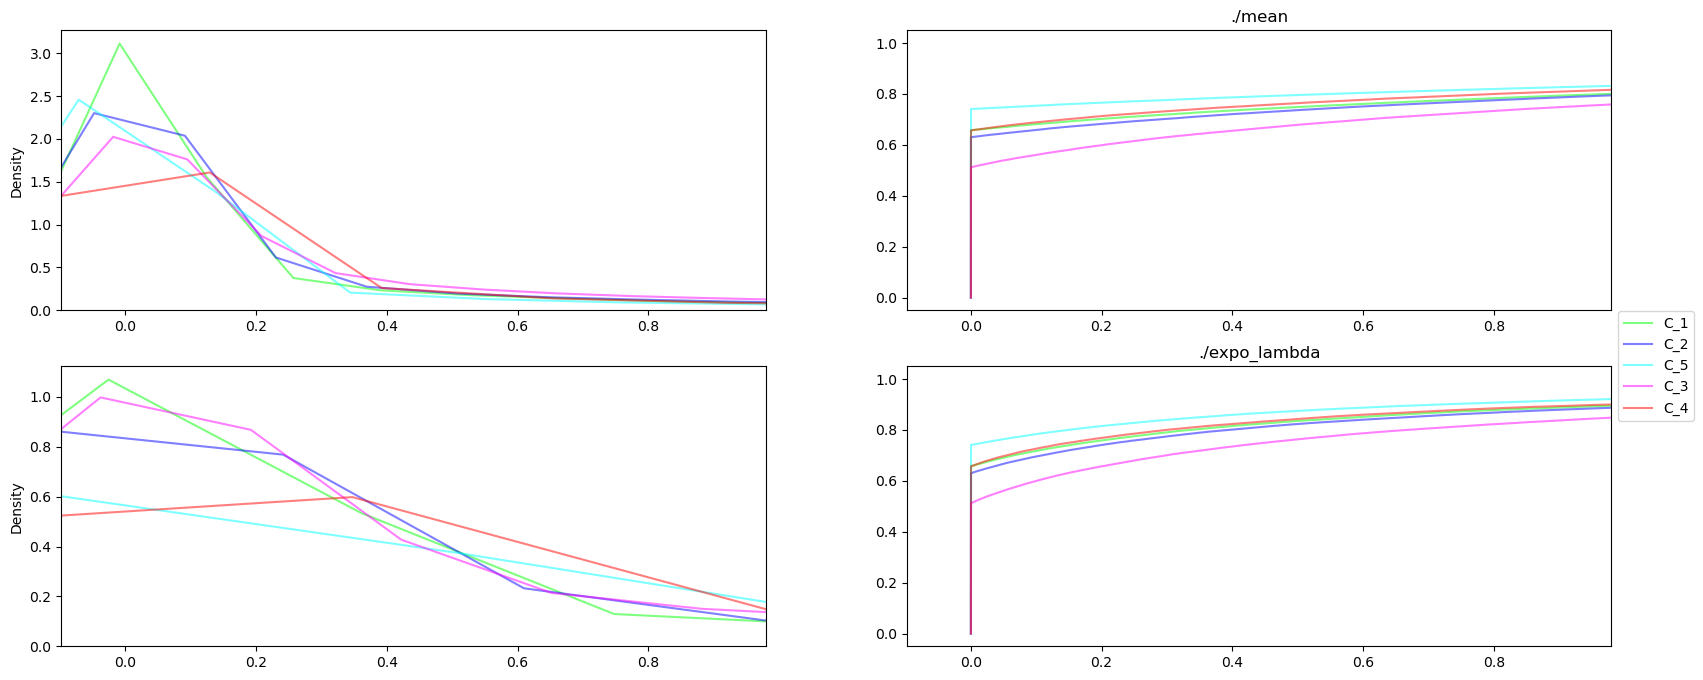

447


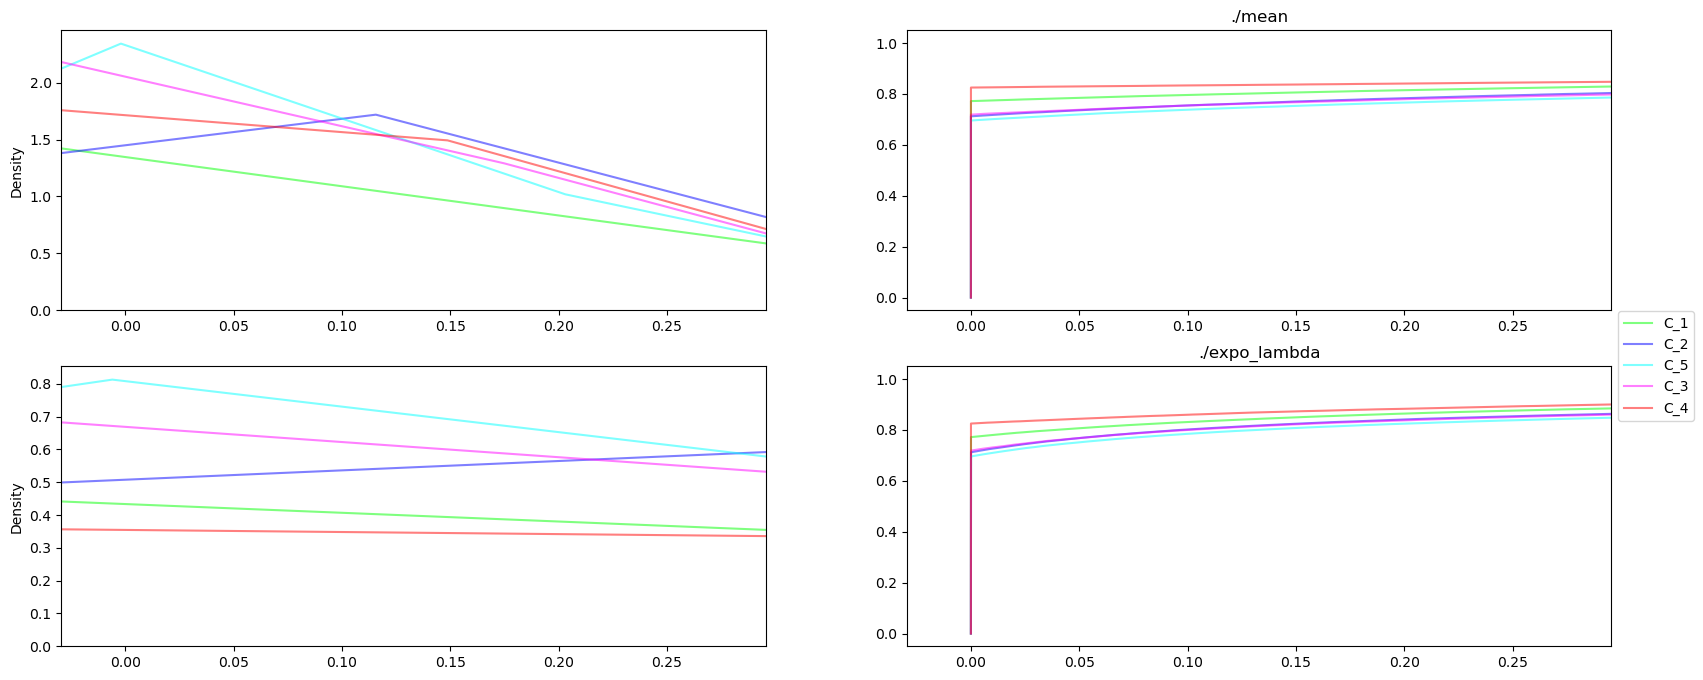

598


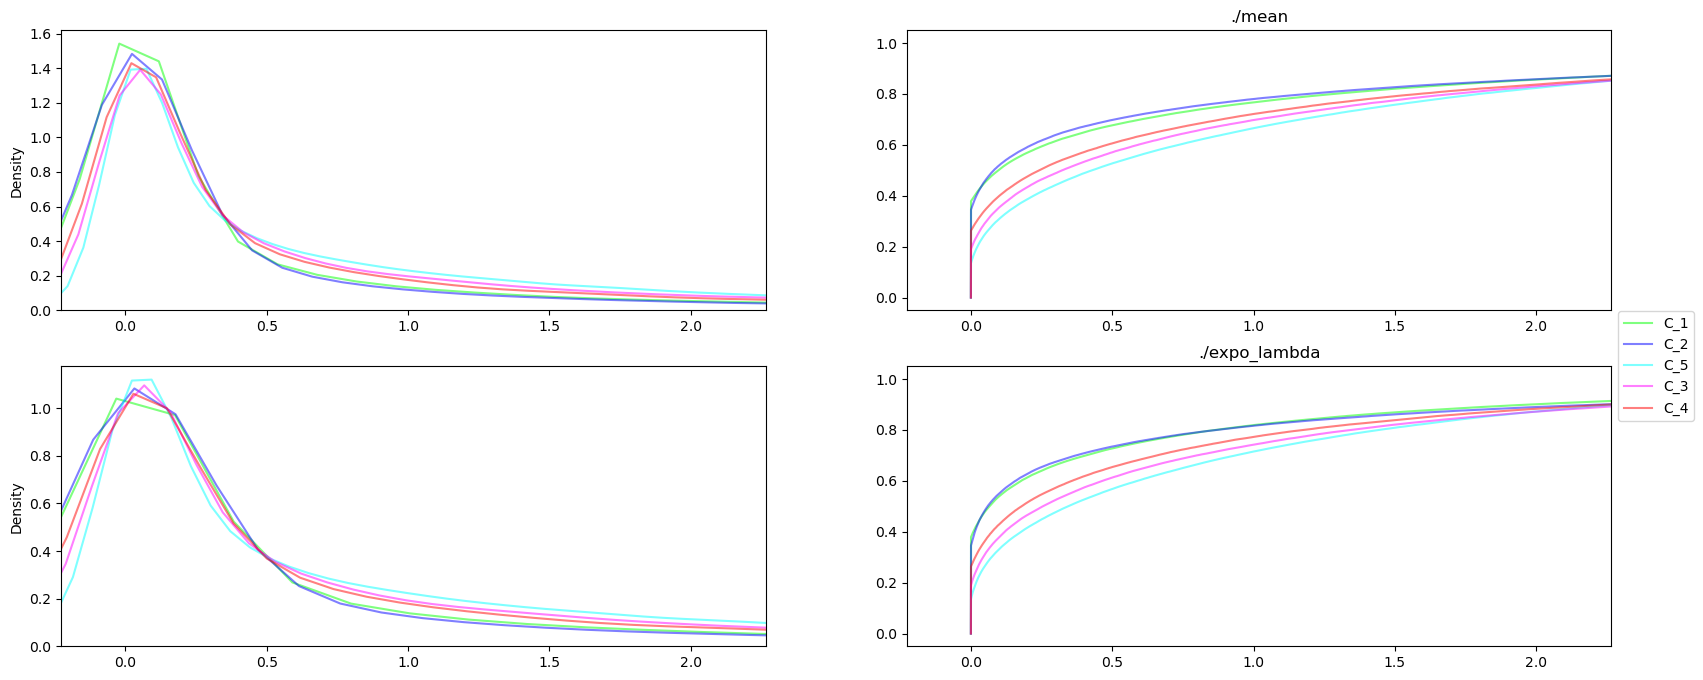

700


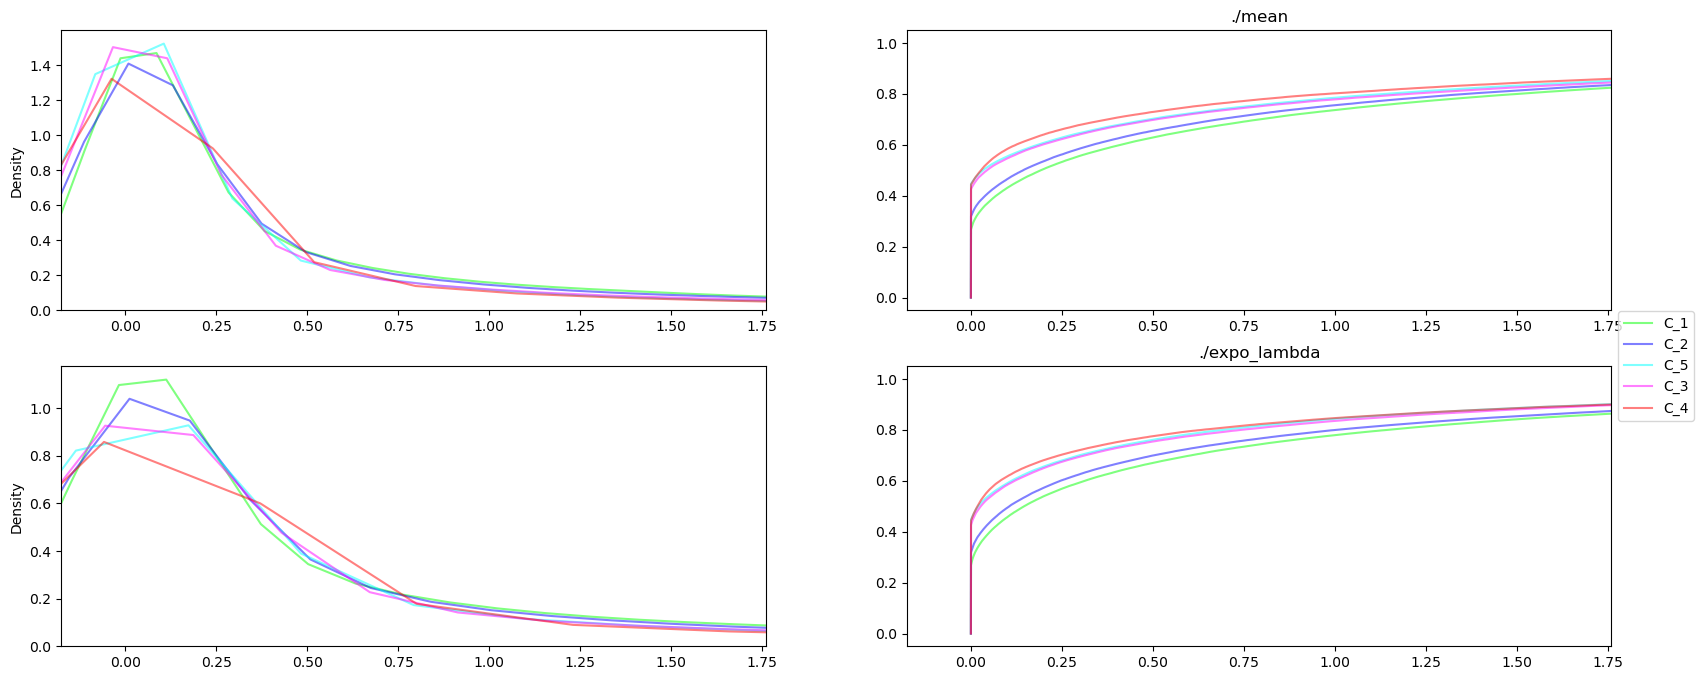

In [27]:
for _ in range(5):
    feature = np.random.randint(0, 2048)
    print(feature)
    fig, ax = plt.subplots(2,2, figsize=(20,8))
    for center in centers:
        values = X_flat_sort[center][:,feature]
        p_all = 1. * np.arange(X_flat_sort[center].shape[0]) / (X_flat_sort[center].shape[0] - 1)
        expo_lambda, mu = find_expo_param(values)

        values_normalized = values/expo_lambda
        q_90 = np.quantile(values_normalized, 0.90)
        sns.kdeplot(values_normalized, ax=ax[0, 0], alpha=0.5, label = f"{center}", color=colors[center])
        ax[1, 1].plot(values_normalized, p_all, alpha=0.5, label = f"{center}", color=colors[center])
        ax[1, 1].set_title("./expo_lambda")
        ax[1, 0].set_xlim(-0.1*q_90,q_90)
        ax[1, 1].set_xlim(-0.1*q_90,q_90)

        values_normalized = values/values.mean()
        sns.kdeplot(values_normalized, ax=ax[1, 0], alpha=0.5, label = f"{center}", color=colors[center])
        ax[0, 1].plot(values_normalized, p_all, alpha=0.5, label = f"{center}", color=colors[center])
        ax[0, 1].set_title("./mean")
        ax[0, 0].set_xlim(-0.1*q_90,q_90)
        ax[0, 1].set_xlim(-0.1*q_90,q_90)

    plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    plt.show()